# Data exploration

This notebook will explore the images we have and extract data from them. The images have 4 channels (DAPI, EdU, and two Alexa's, one being PCNA). The data we extract from the channels are the pixel intensities.

## Importing data

Note: since I'm working from home right now, I'm struggling with my connection to Omero so I'm importing data I saved from earlier. When I'm back in the lab I will change this part to be importing data from Omero with the plate number.

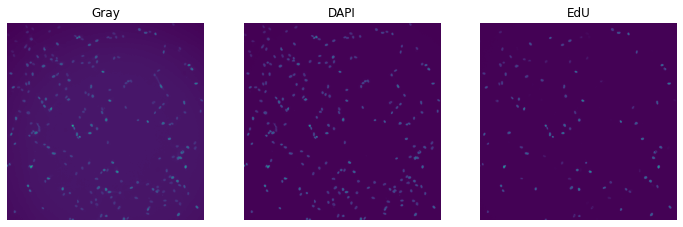

In [7]:
#Here we get the images from a directory in the project and display them

import numpy as np
import matplotlib.pyplot as plt

gray_img = np.load('/Users/rehanzuberi/Documents/Development/cell-SCT/classification/images/gray_img.npy')
dapi_img = np.load('/Users/rehanzuberi/Documents/Development/cell-SCT/classification/images/dapi_img.npy')
edu_img = np.load('/Users/rehanzuberi/Documents/Development/cell-SCT/classification/images/cy5_img.npy')

plt.figure(figsize=(12,12))
plt.subplot(1,3,1);plt.imshow(gray_img);plt.axis('off');plt.title('Gray')
plt.subplot(1,3,2);plt.imshow(dapi_img);plt.axis('off');plt.title('DAPI')
plt.subplot(1,3,3);plt.imshow(edu_img);plt.axis('off');plt.title('EdU');plt.show()

In [9]:
#Make a segmentation prediction, right now with the Gray image as that's all we have, later with the Alexa555 (PCNA) image

from segmentation.seg_functions import make_predictions, display_imgs

predictions = make_predictions(model_dir,images_dir)
display_imgs(predictions)

ModuleNotFoundError: No module named 'cv2'